# Experiment Notebook: Numerosity-Based Categorization (One-Run Setup) - MPEG7

**Objective:**  
Train a CNN on the synthetic dot dataset (saved as `train_dataset.pt`, `val_dataset.pt`, and `test_dataset.pt`) to classify images into three categories (Few, Medium, Many).  

**Goals:**
- Run multiple experiments (5+ runs) to account for randomness.
- Perform hyperparameter tuning.
- Record results in tables and visualize training curves, confusion matrices, and classification reports.
- Use a validation set for hyperparameter tuning.

**Configuration**
- Seed: 42
- Learning Rate: 0.0001
- Batch Size: 256
- Epochs: 20 (with early stopping)


# Set Seed for Reproducibility

In [1]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    # Ensure deterministic behavior on cuDNN backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)
print("Random seed set to 42 for reproducibility.")

Random seed set to 42 for reproducibility.


# Import Libraries and Setup Device

In [2]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os
import tarfile
import urllib.request
import cv2
import glob
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")

Using device: NVIDIA L4


# MPEG7 Dataset Generation

In [4]:
!apt-get install -y libglib2.0-0 libsm6 libxrender1 libxext6
!pip install opencv-python matplotlib -q

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsm6 is already the newest version (2:1.2.3-1build2).
libxext6 is already the newest version (2:1.3.4-1build1).
libxrender1 is already the newest version (1:0.9.10-1build4).
libxrender1 set to manually installed.
libglib2.0-0 is already the newest version (2.72.4-0ubuntu2.4).
libglib2.0-0 set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


# Download & Extract MPEG-7 Shape Dataset

In [5]:
DATASET_URL = "https://dabi.temple.edu/external/shape/MPEG7/MPEG7dataset.zip"
ZIP_PATH = "./mpeg7.zip"
EXTRACT_DIR = "./mpeg7"
SILHOUETTE_DIR = os.path.join(EXTRACT_DIR, "original")

In [6]:
if not os.path.exists(SILHOUETTE_DIR):
    print("Downloading MPEG-7 Dataset...")
    urllib.request.urlretrieve(DATASET_URL, ZIP_PATH)

    print("Extracting...")
    import zipfile
    with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
        zip_ref.extractall(EXTRACT_DIR)
    print("Download and extraction complete.")
else:
    print("Dataset already exists.")

Extracting...
Download and extraction complete.


# Visualize Sample Silhouettes

In [7]:
!pip install imageio -q

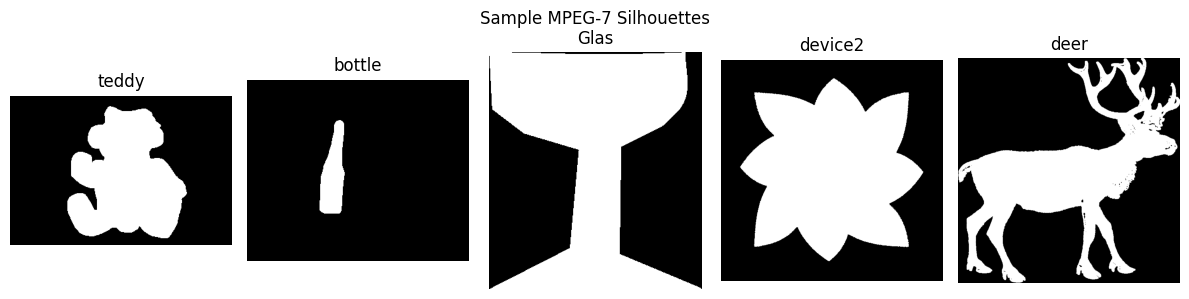

In [8]:
import imageio.v3 as iio

all_gifs = sorted(glob.glob(os.path.join(SILHOUETTE_DIR, "*.gif")))
plt.figure(figsize=(12, 3))
for i, path in enumerate(random.sample(all_gifs, 5)):
    img = iio.imread(path)[0]  # Select the first frame-
    plt.subplot(1, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(os.path.basename(path).split("-")[0])
    plt.axis("off")
plt.suptitle("Sample MPEG-7 Silhouettes")
plt.tight_layout()
plt.show()

# Generate Numerosity Images from Silhouettes

In [9]:
OUTPUT_DIR = "./numerosity_mpeg7"
os.makedirs(OUTPUT_DIR, exist_ok=True)

LABELS = {0: "Few", 1: "Medium", 2: "Many"}
CATEGORY_THRESHOLDS = [5, 15]  # Few: 1-5, Medium: 6-15, Many: 16-30
IMAGE_SIZE = 128
NUM_IMAGES = 3000

In [10]:
import glob
import imageio.v3 as iio

print("Loading silhouette images...")
silhouette_images = []
img_paths = glob.glob(os.path.join(SILHOUETTE_DIR, '*.gif'))
for path in img_paths:
    try:
        img = iio.imread(path)[0]
        if img is not None:
            silhouette_images.append(img)
    except Exception as e:
        print(f"Failed to read {path}: {e}")

print(f"Loaded {len(silhouette_images)} silhouettes.")

Loading silhouette images...
Loaded 1402 silhouettes.


In [11]:
# Categorize numerosity
def categorize(count):
    if count <= CATEGORY_THRESHOLDS[0]: return 0
    elif count <= CATEGORY_THRESHOLDS[1]: return 1
    else: return 2

# Composite image generator
def generate_composite():
    canvas = np.zeros((IMAGE_SIZE, IMAGE_SIZE), dtype=np.uint8)
    num_shapes = random.randint(1, 30)

    shape = random.choice(silhouette_images)
    if len(shape.shape) > 2:
        shape = cv2.cvtColor(shape, cv2.COLOR_BGR2GRAY)

    shape = cv2.resize(shape, (random.randint(20, 40), random.randint(20, 40)))
    h, w = shape.shape

    for _ in range(num_shapes):
        x = random.randint(0, IMAGE_SIZE - w)
        y = random.randint(0, IMAGE_SIZE - h)
        roi = canvas[y:y+h, x:x+w]
        canvas[y:y+h, x:x+w] = np.maximum(roi, (shape > 127).astype(np.uint8) * 255)

    return canvas, categorize(num_shapes)
# Generate and save images
print("Generating dataset...")
for i in tqdm(range(NUM_IMAGES)):
    img, label = generate_composite()
    save_path = os.path.join(OUTPUT_DIR, f"img_{i:04d}_label_{label}.png")
    cv2.imwrite(save_path, img)
print("Numerosity dataset generation complete!")

Generating dataset...


100%|██████████| 3000/3000 [00:01<00:00, 2225.53it/s]

Numerosity dataset generation complete!


# Visualize Samples

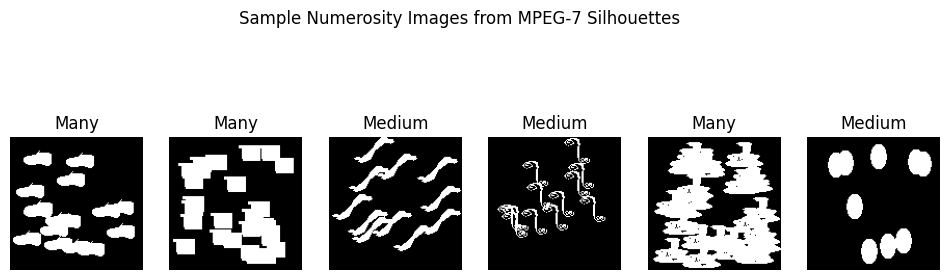

In [12]:
samples = random.sample(glob.glob(os.path.join(OUTPUT_DIR, '*.png')), 6)
plt.figure(figsize=(12, 4))
for i, path in enumerate(samples):
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    label = LABELS[int(path.split('_')[-1].split('.')[0])]
    plt.subplot(1, 6, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(label)
    plt.axis('off')
plt.suptitle("Sample Numerosity Images from MPEG-7 Silhouettes")
plt.show()

# Prepare Dataset for Model

In [13]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, random_split
from PIL import Image
import os

# Step 1: Define a custom dataset
class NumerositySilhouetteDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        path = self.image_paths[idx]
        img = Image.open(path).convert("L")
        label = int(path.split("_")[-1].split(".")[0])
        if self.transform:
            img = self.transform(img)
        return img, label

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),               # Converts to [C x H x W], with range [0,1]
    transforms.Normalize((0.5,), (0.5,)) # Normalize grayscale to [-1, 1]
])

In [15]:
dataset = NumerositySilhouetteDataset(OUTPUT_DIR, transform=transform)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(42))

In [16]:
torch.save(train_dataset, "train_dataset.pt")
torch.save(val_dataset, "val_dataset.pt")
torch.save(test_dataset, "test_dataset.pt")

print(f"Saved: {len(train_dataset)} train / {len(val_dataset)} val / {len(test_dataset)} test")

Saved: 2100 train / 450 val / 450 test


# Define the Model Architecture

In [17]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

class NumerosityCNNTransformer(nn.Module):
    def __init__(self, image_size=128, patch_size=4, embed_dim=128, num_heads=4, num_layers=2, num_classes=3):
        super(NumerosityCNNTransformer, self).__init__()

        # CNN Backbone with Residual Blocks
        self.cnn_layers = nn.Sequential(
            ResidualBlock(1, 32),
            nn.MaxPool2d(2),  # 64x64
            ResidualBlock(32, 64),
            nn.MaxPool2d(2),  # 32x32
            ResidualBlock(64, 128),
            nn.MaxPool2d(2)   # 16x16
        )

        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.num_patches = (16 // patch_size) ** 2

        # Patch embedding using convolution
        self.patch_embedding = nn.Conv2d(128, embed_dim, kernel_size=patch_size, stride=patch_size, bias=False)
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Regularization & Classification Head
        self.layer_norm = nn.LayerNorm(embed_dim)  # Stabilizes Transformer Output
        self.dropout = nn.Dropout(p=0.4)  # Increased for better regularization
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        out = self.cnn_layers(x)  # [batch_size, 128, 16, 16]

        # Convert CNN features into patches
        patches = self.patch_embedding(out)  # [batch_size, embed_dim, H', W']
        patches = patches.flatten(2).transpose(1, 2)  # [batch_size, num_patches, embed_dim]

        # Add positional encoding
        patches += self.pos_embedding

        # Transformer processing
        transformer_out = self.transformer_encoder(patches)

        # Pooled output & classification
        pooled_out = transformer_out.mean(dim=1)  # Global average pooling
        pooled_out = self.layer_norm(pooled_out)  # Normalize before final FC
        pooled_out = self.dropout(pooled_out)

        return self.fc(pooled_out)

# Training and Evaluation Functions

In [18]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, grad_clip=1.0):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()

        # Apply Gradient Clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_labels, all_preds = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    avg_loss = running_loss / len(dataloader)
    accuracy = np.mean(np.array(all_labels) == np.array(all_preds))
    return avg_loss, accuracy, all_labels, all_preds

def run_experiment(num_epochs=20, learning_rate=0.0001, batch_size=256, early_stop_patience=5, accumulation_steps=2):

    set_seed(42)

    # Create DataLoaders for the current run (can vary batch_size)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, optimizer, and loss function
    model = NumerosityCNNTransformer().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=5e-4, eps=1e-6, betas=(0.9, 0.98))
    criterion = nn.CrossEntropyLoss()

    # To store the training history
    train_losses, val_losses, val_accuracies = [], [], []
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy, _, _ = evaluate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy*100:.2f}%")

        # Early stopping check based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict()
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    # Load the best model state before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, train_losses, val_losses, val_accuracies

In [19]:
import warnings
warnings.filterwarnings("ignore", message="You are using `torch.load` with `weights_only=False`")

from torch.utils.data.dataset import Subset
import torch.serialization

torch.serialization.add_safe_globals([Subset])

# Load the saved datasets (train, validation, test)
train_dataset = torch.load("train_dataset.pt", weights_only=False)
val_dataset = torch.load("val_dataset.pt", weights_only=False)
test_dataset = torch.load("test_dataset.pt", weights_only=False)

print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Train Dataset Size: 2100
Validation Dataset Size: 450
Test Dataset Size: 450


# Running Single Run Experiment

In [20]:
print(f"\n--- Starting Experiment Run  ---")
model, train_losses, val_losses, val_accuracies = run_experiment(num_epochs=20, learning_rate=0.0001, batch_size=256)

print("\n--- Experiment Completed ---")


--- Starting Experiment Run  ---
Epoch [1/20], Train Loss: 0.8440, Val Loss: 2.6434, Val Acc: 17.78%
Epoch [2/20], Train Loss: 0.5575, Val Loss: 3.5014, Val Acc: 18.00%
Epoch [3/20], Train Loss: 0.5048, Val Loss: 2.2426, Val Acc: 28.00%
Epoch [4/20], Train Loss: 0.4485, Val Loss: 0.7734, Val Acc: 66.22%
Epoch [5/20], Train Loss: 0.4696, Val Loss: 0.5100, Val Acc: 76.22%
Epoch [6/20], Train Loss: 0.4386, Val Loss: 0.4345, Val Acc: 78.89%
Epoch [7/20], Train Loss: 0.4046, Val Loss: 0.4297, Val Acc: 78.89%
Epoch [8/20], Train Loss: 0.3930, Val Loss: 0.4684, Val Acc: 79.11%
Epoch [9/20], Train Loss: 0.4004, Val Loss: 0.4536, Val Acc: 79.33%
Epoch [10/20], Train Loss: 0.3511, Val Loss: 0.4137, Val Acc: 81.78%
Epoch [11/20], Train Loss: 0.3269, Val Loss: 0.4871, Val Acc: 78.67%
Epoch [12/20], Train Loss: 0.3652, Val Loss: 0.5743, Val Acc: 76.67%
Epoch [13/20], Train Loss: 0.3480, Val Loss: 0.5269, Val Acc: 78.89%
Epoch [14/20], Train Loss: 0.2800, Val Loss: 0.4147, Val Acc: 82.89%
Epoch [15

# Evaluation of Test set & visualization

Test Loss: 0.4116, Test Accuracy: 82.22%


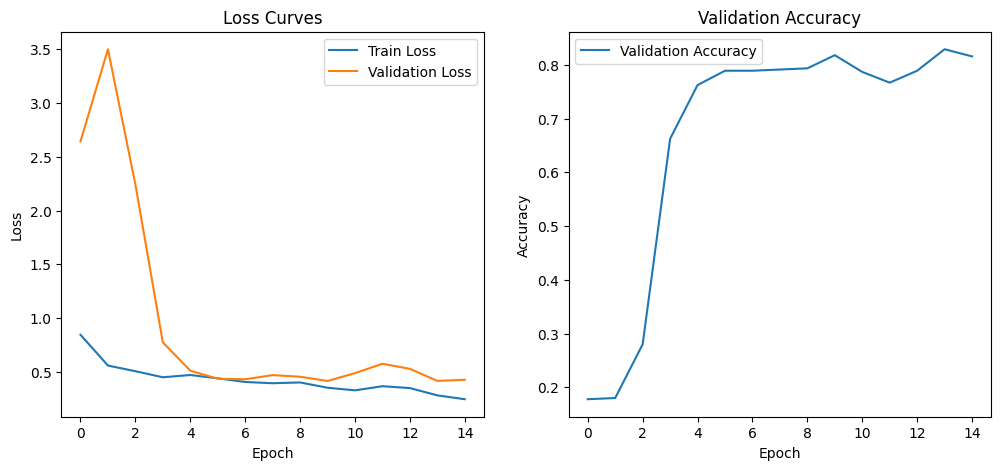

In [21]:
test_loss, test_accuracy, test_labels, test_preds = evaluate(model, test_loader, nn.CrossEntropyLoss(), device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy*100:.2f}%")

# Plot Loss and Accuracy Curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()

plt.show()

# Confusion Matrix

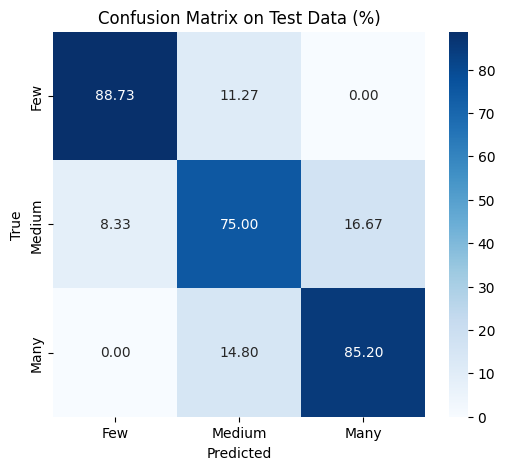

Classification Report:
              precision    recall  f1-score   support

         Few       0.83      0.89      0.86        71
      Medium       0.74      0.75      0.75       156
        Many       0.88      0.85      0.87       223

    accuracy                           0.82       450
   macro avg       0.82      0.83      0.82       450
weighted avg       0.82      0.82      0.82       450



In [22]:
cm = confusion_matrix(test_labels, test_preds)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100  # Convert to percentages

plt.figure(figsize=(6, 5))
sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=["Few", "Medium", "Many"],
            yticklabels=["Few", "Medium", "Many"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix on Test Data (%)")
plt.show()

print("Classification Report:")
print(classification_report(test_labels, test_preds, target_names=["Few", "Medium", "Many"]))

# Save final model & results

In [23]:
torch.save(model.state_dict(), "final_numerosity_model.pt")
print("Final model saved as 'final_numerosity_model.pt'.")

results_dict = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "val_accuracies": val_accuracies,
    "test_loss": test_loss,
    "test_accuracy": test_accuracy
}
pd.DataFrame(results_dict).to_csv("experiment_results_run.csv", index=False)
print("Experiment results saved as 'experiment_results_run.csv'.")

Final model saved as 'final_numerosity_model.pt'.
Experiment results saved as 'experiment_results_run.csv'.


# Visualize Test Images with Predictions

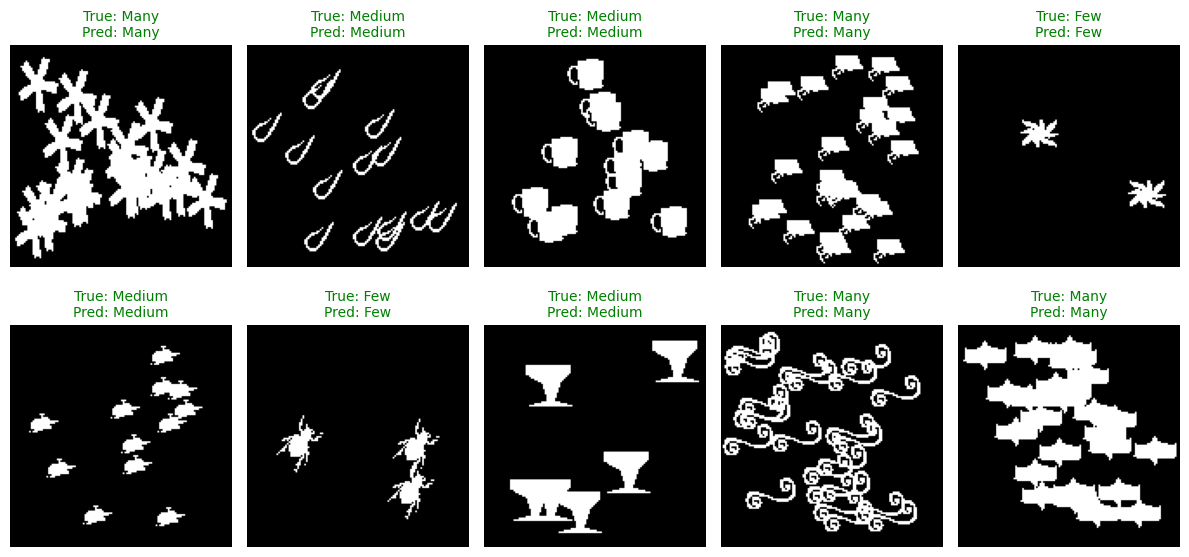

In [24]:
# Get a batch of test images
model.eval()
images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

# Get model predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Map numeric labels to class names
label_names = {0: "Few", 1: "Medium", 2: "Many"}

# Plot images with predictions
plt.figure(figsize=(12, 6))
for i in range(10):  # Show 10 sample test images
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].cpu().squeeze(), cmap="gray")
    true_label = label_names[labels[i].item()]
    pred_label = label_names[predicted[i].item()]
    plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color="green" if true_label == pred_label else "red")
    plt.axis("off")

plt.tight_layout()
plt.show()